# Training Atnal and using it to recognize prostate cancer regions, subsequently also using it to recognize the potential biomarkers.

In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib inline
import numpy as np
np.random.seed(1337)
import torch
import torch.nn as nn
torch.manual_seed(1307)#为CPU设置随机种子 
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(1307)#为当前GPU设置随机种子 
import os
import h5py
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import time

# ========= Color Map ==============                                      
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


## Data loading

In [6]:

f =  h5py.File('./data/Prostate/P_1900.h5','r')  
MSI_train = np.array(f["Data"])  # spectral information.
All_mz = np.array(f["mzArray"] )
nSpecFeatures = len(All_mz)
if MSI_train.shape[1] != nSpecFeatures:
    MSI_train = np.transpose(MSI_train)
tic_sum=np.sum(MSI_train,axis=-1)[:,None]
MSI_train=MSI_train/tic_sum
xLocation = np.array(f["xLocation"]).astype(int)-1
yLocation = np.array(f["yLocation"]).astype(int)-1
col = max(np.unique(xLocation))+1
row = max(np.unique(yLocation))+1
im = np.zeros((col,row))
mzId = np.argmin(np.abs(All_mz[:] - 2509.6))
f.close()


## Illustrate the ion around 12000.6

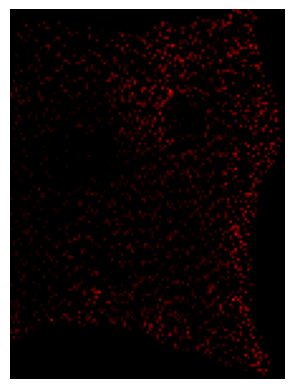

In [8]:
import matplotlib.colors as colors
im = np.zeros((col,row))
mzId = np.argmin(np.abs(All_mz[:] - 12000.6))
cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, 0, 0), (1, 0, 0)], N=256)
# 找mz值接近于6227.9的时候，用所有数据坐标和强度绘图
for i in range(len(xLocation)):
    im[ xLocation[i].item()-1, yLocation[i].item()-1] = MSI_train[i,mzId] #image index starts at 0 not 1
plt.imshow(im,cmap=cmap)

plt.grid(color=[0,0,0], linestyle='-', linewidth=0.5)
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# plt.colorbar();plt.title(f'm/z={All_mz[mzId]}')
plt.show()

## Traing

C:\Users\22767\AppData\Local\Temp\ipykernel_15552\890607956.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSI_train=torch.tensor(MSI_train,dtype=torch.float32)
C:\Users\22767\AppData\Local\Temp\ipykernel_15552\890607956.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xLocation=torch.tensor(xLocation)
C:\Users\22767\AppData\Local\Temp\ipykernel_15552\890607956.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yLocation=torch.tensor(yLocation)
c:\Users\22767\.conda\envs\torch\Lib\site-packages\torch\nn\modules\transformer.py:282

avg loss in epoch 0:10.570697040557862 Time/epoch:12.320328950881958s
avg loss in epoch 1:9.853747692108154 Time/epoch:12.21016240119934s
avg loss in epoch 2:9.25163694381714 Time/epoch:12.239725112915039s
avg loss in epoch 3:8.848072566986083 Time/epoch:12.390596866607666s
avg loss in epoch 4:8.62188404083252 Time/epoch:12.209604740142822s
avg loss in epoch 5:8.495815353393555 Time/epoch:13.46222972869873s
avg loss in epoch 6:8.416263942718507 Time/epoch:12.422734022140503s
avg loss in epoch 7:8.364252090454102 Time/epoch:13.438284397125244s
avg loss in epoch 8:8.326668891906738 Time/epoch:15.360105037689209s
avg loss in epoch 9:8.301008167266845 Time/epoch:16.463199853897095s
avg loss in epoch 10:8.2839404296875 Time/epoch:13.435394048690796s
avg loss in epoch 11:8.274554862976075 Time/epoch:13.613683462142944s
avg loss in epoch 12:8.26978744506836 Time/epoch:13.621416330337524s
avg loss in epoch 13:8.260094795227051 Time/epoch:12.73327898979187s
avg loss in epoch 14:8.25484043121338

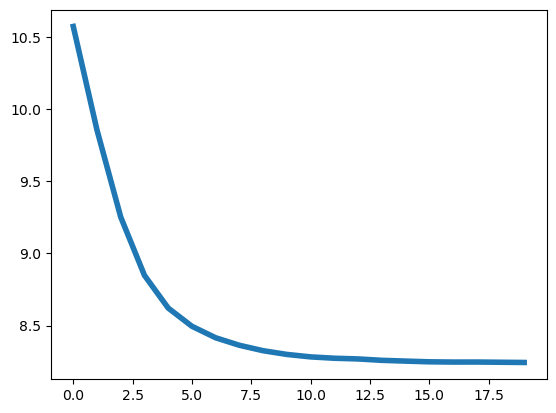

In [16]:
from torch.autograd import Variable
from torch.utils.data import Dataset
import math
import torch.optim as optim
from Computational_Model_trans import *
MSI_train=torch.tensor(MSI_train,dtype=torch.float32)
xLocation=torch.tensor(xLocation)
yLocation=torch.tensor(yLocation)
os.makedirs('./Saved_models', exist_ok=True)
class MSIdataset(Dataset):
    def __init__(self, data,xLoc,yLoc):
        self.len = len(data)
        self.data = data
        self.xLoc=xLoc
        self.yLoc=yLoc
    def __getitem__(self, index):
        return self.data[index],self.xLoc[index],self.yLoc[index]
    def __len__(self):
        return self.len



batchsize=256
epochs=20
lr=1e-4
d_model=256
device=torch.device('cuda')
All_dataset=MSIdataset(MSI_train,xLocation,yLocation)
dataloader = torch.utils.data.DataLoader(All_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=0)
loss_function=categorical_crossentropy
model = Model_trans( d_mz=len(All_mz),
                 d_model=d_model, encoder_layer_num=1,device = device)

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
if True:
    for epoch in range(epochs):
        time1=time.time()
        loss_in_epoch=[]
        model.train()
        for i,(data,xLoc,yLoc) in enumerate(dataloader):
            data=data.to(device)
            loss = loss_function(model(data), data)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_in_epoch.append(loss.item())
        time2=time.time()
        model.log['training loss'].append(np.mean(loss_in_epoch))
        print(f'avg loss in epoch {epoch}:{np.mean(loss_in_epoch)} Time/epoch:{(time2-time1)}s')
        
model.eval()
model.to('cpu')
plt.plot(np.arange(epochs), model.log['training loss'], lw=4)
plt.show()
torch.save(model.state_dict(), './Saved_models/TrainedModel_prostate_trans.h5')

## Visualizing Model Performance

mean squared error(mse)  =  tensor(7.5840e-09)


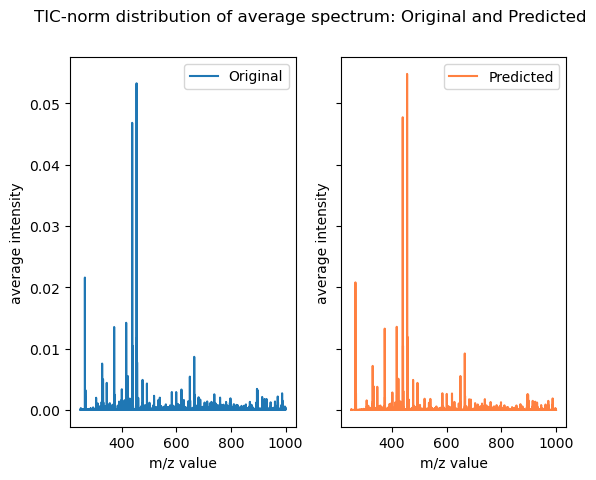

In [18]:
os.makedirs('./pic/prostate',exist_ok=True)
with torch.no_grad():
    #Encoder=nn.Sequential(detr.backbone,detr.transformer.encoder)
    decoded_imgs = model(MSI_train) # Learned non-linear manifold
    
    mse = nn.MSELoss()(MSI_train,decoded_imgs)
    meanSpec_Rec = torch.mean(decoded_imgs,axis=0) 
    print('mean squared error(mse)  = ', mse.item())
    
    meanSpec_Orig = torch.mean(MSI_train,axis=0) # TIC-norm original MSI Data
    meanSpec_Rec = torch.mean(decoded_imgs, axis=0)
    
    fig,axes=plt.subplots(nrows=1,ncols=2,sharey=True)
    plt.suptitle('TIC-norm distribution of average spectrum: Original and Predicted')
    axes[0].set_xlabel('m/z value');axes[0].set_ylabel('average intensity');
    axes[1].set_xlabel('m/z value');axes[1].set_ylabel('average intensity')
    axes[0].plot(All_mz,meanSpec_Orig.detach().numpy(),label='Original'); 
    axes[0].legend()
    axes[1].plot(All_mz, meanSpec_Rec.detach().numpy(),
                 color=[1.0, 0.5, 0.25], label='Predicted')
    axes[1].legend()
    plt.savefig('./pic/prostate/ori_pre.png',bbox_inches='tight',dpi=1000)  

(212.50490493774413,
 1037.4309013366699,
 -0.060178810730576515,
 0.058648401871323586)

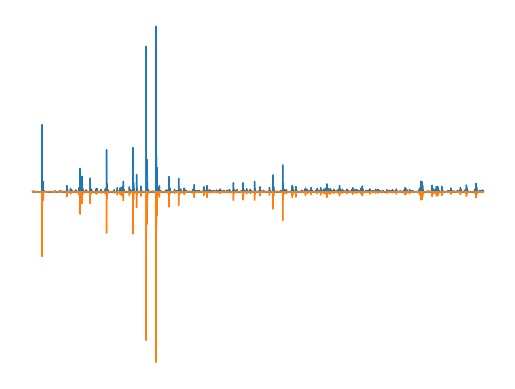

In [20]:
plt.plot(All_mz,meanSpec_Orig.detach().numpy(),linewidth=1)
plt.plot(All_mz,-meanSpec_Rec.detach().numpy(),linewidth=1)
plt.axis(False)
#plt.savefig('Template/pic/prostate/ori_pre.png',bbox_inches='tight',dpi=1000)  

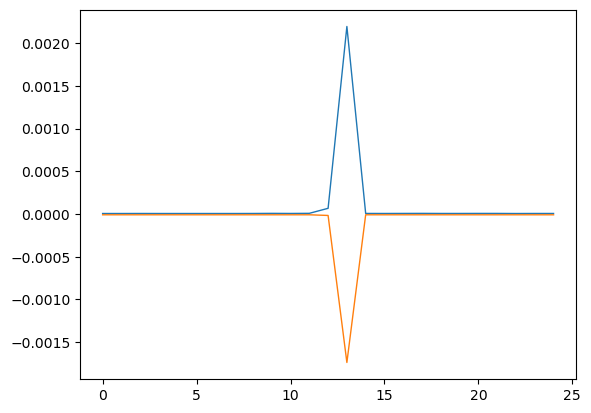

In [21]:

plt.plot(meanSpec_Orig.detach().numpy()[6400:6425],linewidth=1)
plt.plot(-meanSpec_Rec.detach().numpy()[6400:6425],linewidth=1)
# plt.axis(False)
#plt.savefig('Template/pic/prostate/ori_pre.png',bbox_inches='tight',dpi=1000)  

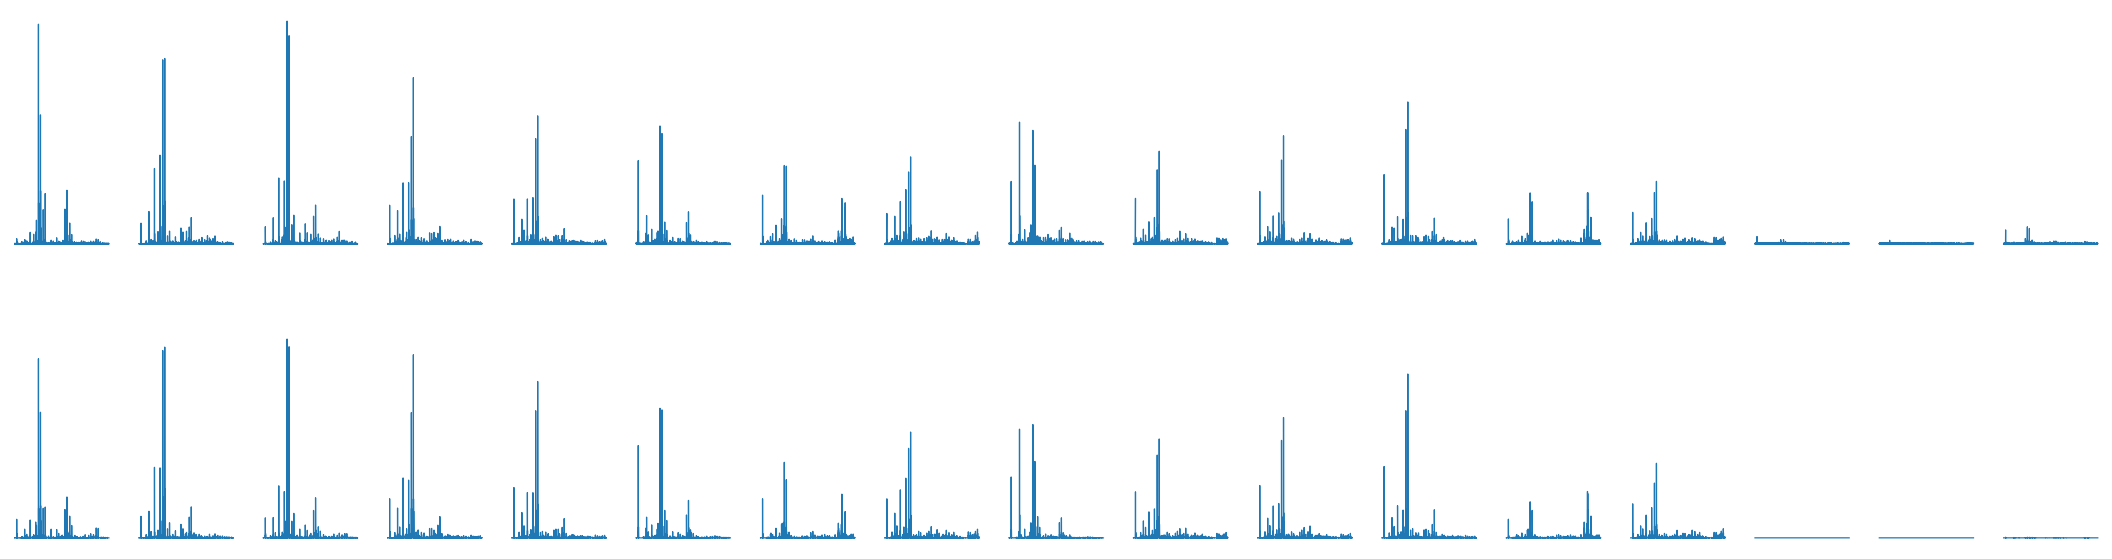

In [22]:
index=[0,500,1000,1500,2000,2500,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,12699]
fig,axes=plt.subplots(nrows=2,ncols=len(index),sharey=True,figsize=(27, 7))
for id,num in enumerate(index):
    axes[0,id].plot(All_mz,MSI_train[num],linewidth=0.9)
    if id!=0:
        axes[0,id].set_yticks([])
    axes[0,id].set_xticks([])
    axes[0,id].spines['top'].set_visible(False)
    axes[0,id].spines['right'].set_visible(False)
    axes[0,id].spines['bottom'].set_visible(False)
    axes[0,id].spines['left'].set_visible(False)
for id,num in enumerate(index):
    axes[1,id].plot(All_mz,decoded_imgs[num].detach().numpy(),linewidth=0.9)
    if id!=0:
        axes[1,id].set_yticks([])
    axes[1,id].set_xticks([])
    axes[1,id].spines['top'].set_visible(False)
    axes[1,id].spines['right'].set_visible(False)
    axes[1,id].spines['bottom'].set_visible(False)
    axes[1,id].spines['left'].set_visible(False)

## Clustering analysis

In [23]:

encoder=nn.Sequential(model.backbone,model.transformerencoder)
encoder.eval()
Latent_z=encoder(MSI_train).detach().numpy()
MSI_train=MSI_train.detach().numpy()
xLocation=xLocation.detach().numpy()
yLocation=yLocation.detach().numpy()




### Illustrate the images which in latent space

(-0.5, 108.5, 146.5, -0.5)

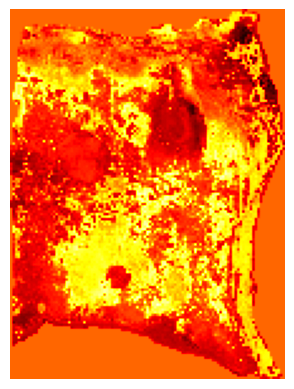

In [24]:
ndim = d_model
im=np.zeros(shape=(col,row))
j=100
for i in range(len(xLocation)):
    im[ xLocation[i], yLocation[i]] = Latent_z[i,j]  

plt.imshow(im,cmap="hot");  # plt.colorbar()   
plt.axis(False)

### GMM

C:\Users\22767\AppData\Local\Temp\ipykernel_15552\179632745.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap)


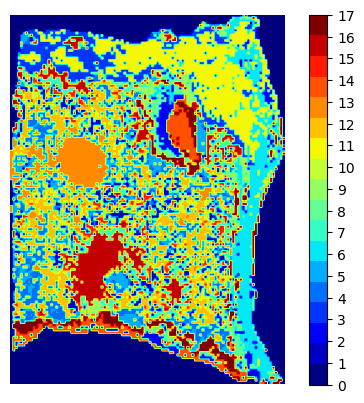

In [26]:
from sklearn.mixture import GaussianMixture
#n_clusters=(kneedle_point.knee)
n_clusters=17
gmm=GaussianMixture(n_components=n_clusters,covariance_type='full',random_state=0).fit(Latent_z)
labels = gmm.predict(Latent_z)
labels+=1
im=np.full(shape=(col,row),fill_value=0)
for i in range(len(xLocation)):
    im[ xLocation[i], yLocation[i]] = labels[i]
MyCmap = discrete_cmap(n_clusters+1, 'jet')
plt.imshow(im,cmap=MyCmap);
plt.colorbar(ticks=np.arange(0,n_clusters+1,1))
plt.axis('off')
plt.savefig('./pic/prostate/gmm_all.png',bbox_inches='tight',dpi=100)

### Select the one cluster which matches the cancer region best

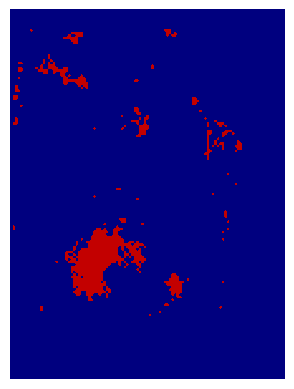

In [48]:
cluster_id = 16  # manually select the one cluster which matches the cancer region best
im=np.full(shape=(col,row),fill_value=0)
Kimg = labels==cluster_id
Kimg = Kimg.astype(int)

for i in range(len(xLocation)):
    im[ xLocation[i], yLocation[i]] = Kimg[i]
segCmp = [MyCmap(0),MyCmap(cluster_id)]
cm = LinearSegmentedColormap.from_list('Walid_cmp',segCmp,N=2)
plt.imshow(im, cmap=cm);
plt.axis('off')
plt.savefig('./pic/prostate/gmm_selected.png',bbox_inches='tight',dpi=100)

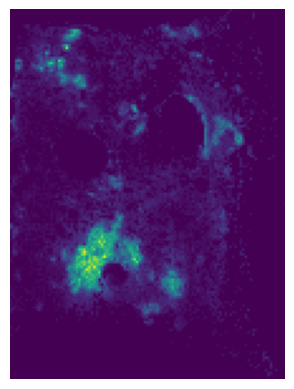

m/z 774.59827
corr_Value =  0.7772493088209448
['774.5983', '775.6025', '760.5827', '761.5867', '253.5388', '845.6712', '884.5723', '762.5862', '380.3034', '504.3485']
Correlation Top 10 Ranked peaks:['0.7772', '0.7635', '0.7477', '0.7435', '0.7406', '0.7403', '0.7378', '0.7317', '0.7287', '0.7244']


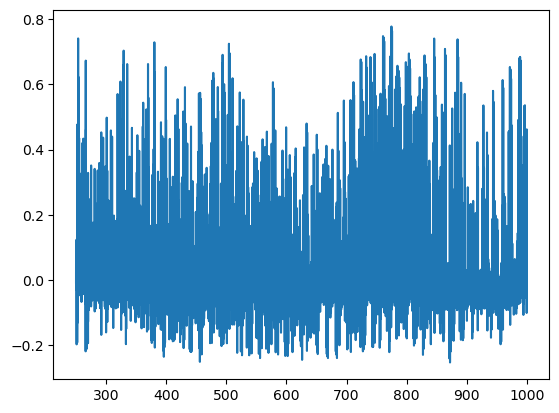

In [49]:

import scipy.stats as stats
Corr_Val =  np.zeros(len(All_mz))
for i in range(len(All_mz)):
    
    Corr_Val[i] = stats.pearsonr(Kimg, MSI_train[:, i])[0]
    # Kimg (clustering result, size=sample_num*1)
# Select the peak with the largest correlation coefficient and record its subscript
id_mzCorr = np.argmax(Corr_Val)
rank_ij =  np.argsort(Corr_Val)[::-1]

im = np.zeros((col,row))

for i in range(len(xLocation)):
    im[ xLocation[i].item()-1, yLocation[i].item()-1] = MSI_train[i,id_mzCorr].item()  
plt.imshow(im)
plt.axis('off')
plt.show()
print('m/z', All_mz[id_mzCorr])
print('corr_Value = ', Corr_Val[id_mzCorr])

plt.plot(All_mz,Corr_Val)
print(['%0.4f' % i for i in All_mz[rank_ij[0:10]]])
print('Correlation Top 10 Ranked peaks:', end='') 
print(['%0.4f' % i for i in Corr_Val[rank_ij[0:10]]])